# Instalaciones e importaciones de librerias y paquetes 

In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install tensorflow==2.1.0
!pip install pillow


In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam #el optimizador 
from tensorflow.keras.preprocessing.image import ImageDataGenerator # para el pre-procesamiento

# Cargando el dataset

En este paso se cargan las imagenes que serán usadas por el modelo. Ademas, se puede vizualizar el total de imagenes por clase. 

In [ ]:
train_dir ='dataset'
val_dir = 'datasetEntramiento'
train_mask_dir = 'dataset/with_mask' #directorio con las imagenes que NO tienen mascara
train_no_mask_dir = 'dataset/without_mask' #directorio con las imagenes que SI tienen mascara

In [ ]:
train_mask_frames = os.listdir(train_mask_dir)
train_no_mask_frames = os.listdir(train_no_mask_dir)

#Imprimiendo las cantidades de imagenes con su clasificación 

print('Cantidad total de imagenes con mascara = ', len(os.listdir(train_mask_dir)))
print('Cantidad total de imagenes sin mascara = ', len(os.listdir(train_no_mask_dir)))

In [ ]:
#Definicion de parametos

longitud, altura = 150, 150 #tamaño, en píxeles el que van hacer procesadas las imagenes

epocas  = 10 #cantidad de veces que se va iterar el set de datos
batch_size = 10 #cant de imagenes que serán procesadas en cada unos de los pasos.

cant_Filtros_Conv1 = 16 # numero de filtros que se van aplicar en la convolucion 1, digase, que luego de la esta convolucion la imagen va a tener una profundida de 16
cant_Filtros_Conv2 = 32 # numero de filtros que se van aplicar en la convolucion 2
cant_Filtros_Conv3 = 64 # numero de filtros que se van aplicar en la convolucion 3
cant_Filtros_Conv4 = 128 # numero de filtros que se van aplicar en la convolucion 4
tamano_filtro = (3,3) # Es el tamaño del filtro que se usaran en las convoluciones
tamano_filtro_MaxPooling = (2, 2) # Es el tamaño del filtro que se usaran en los MaxPooling2D
cant_clases = 2 #cantidad de clase: Con mascara & Sin mascara
#para compilar el modelo
lr = 0.0004 # Es learning rate, digase que tan grande seran los ajustes de la CNN para acercarse a una sol

# Creación del Modelo CNN

Se construye el modelo CNN secuencial, el cual hace la abstracion de caracteristicas y la clasificaciones de las imagenes. A treves de diversas capas, tales como: Conv2D, MaxPooling2D, Flatten, Dropout y Dense


* Conv2D: Añade una capa convolucional 
* MaxPooling2D: Reduce el tamaño de  la imagen. 
* Flatten: Permite convertir los elementos de la matriz de imagenes de entrada en un array plano. En su esencia, lo que hace es acoplar.
* Dense: Permite crear y añadir capas ocultas de la red neuronal
* Dropout: Permite desconectar un porcentaje de las neuronas en cada epoca del entrenamiento. Se hace con el objectivo de evitar sobre ajustar
<p> Referencia -> https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
    

In [ ]:
#nueva prueba
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(cant_Filtros_Conv1, tamano_filtro, activation='relu', input_shape=(altura, longitud, 3)), 
    tf.keras.layers.MaxPooling2D(pool_size=tamano_filtro_MaxPooling), 
    
    tf.keras.layers.Conv2D(cant_Filtros_Conv2, tamano_filtro, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=tamano_filtro_MaxPooling),
    
    tf.keras.layers.Conv2D(cant_Filtros_Conv3, tamano_filtro, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=tamano_filtro_MaxPooling),
    
    
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'), 
    
    tf.keras.layers.Dense(cant_clases, activation='softmax')
    #tf.keras.layers.Dense(1, activation='sigmoid')
])
# softmax lo que da el % de que tenga mascara o no, %80 sin mascara, %20 con mascara 

# Compilando Modelo
En esta parte lo que se realiza es la compilacion del modelo, especificando las funciones de:


*   Optimización: Se usa **Adam**.
*   Coste o pérdida. 
*   Métricas.



In [ ]:
#Compilando el modelo. 
model.compile(
    optimizer=Adam(lr=lr),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

model.summary() #Observando un resumen

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

# Realizando pre-entrenamiento del modelo
Se realizan de los ajuste las imagenes.

In [ ]:
# libreria que se necesitan ->
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) #set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    #val_dir,
    target_size = (altura, longitud),
    batch_size = batch_size,
    #class_mode = 'binary',
    subset = 'training') #set as training data

validation_generator = train_datagen.flow_from_directory( 
    train_dir,
   # val_dir,
    target_size = (altura, longitud),
    batch_size = batch_size,
   # class_mode = 'binary',
    subset = 'validation') #set as validation data
    


# Realizando entrenamientodo del modelo 
Este bloque es lo mas esencial.

In [ ]:

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = epocas)

# Graficas de cambios de la red

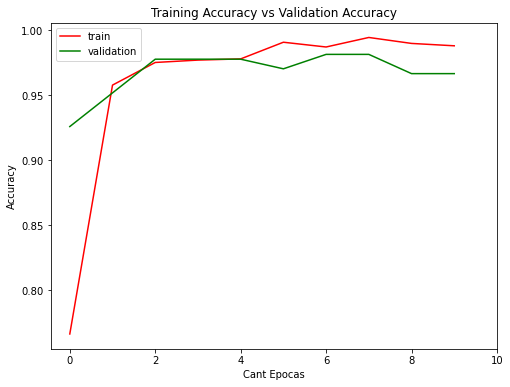

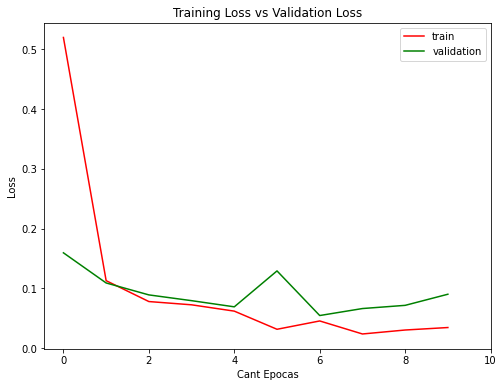

In [ ]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, epocas+1, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Cant Epocas")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, epocas+1, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Cant Epocas")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

# Persistiendo modelo a disco. 
Esto se hace con el conversor de TFLite
TFLite tiene dos componentes:

1.   **El interprete**, para hacer la inferencia
2.   **El conversor**.



In [ ]:
# con TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("P8_clasificador.tflite","wb").write(tflite_model)
# con h5
model.save('P8__modeloClasificador.h5')
model.save_weights('P8_pesos.h5')


# Prueba de dectecion

Importando .xml para detecion de rostro

In [ ]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

Capturando video en tiempo real. Pero, el modelo con el cual se trabaja el mismo entrenado. Se debe investigar para que el modelo que se le pase sea que se persistio en disco.

In [ ]:
from tensorflow.keras.models import load_model

labels_dict={0:'Sin Mascara',1:'Con Mascara'}
color_dict={0:(0,0,255),1:(0,255,0)}

# realizando lectura  del modelo serealizado
modelo = 'P5__modeloClasificador.h5' # bueno 'modeloClasificador.h5'
pesos = 'P5_pesos.h5' # 'pesos.h5'

modeloCargado = load_model(modelo)
modeloCargado.load_weights(pesos)

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        print('rostro dectetado')
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=modeloCargado.predict(reshaped)
        #result = P6__modeloClasificador.h5
        #result=model.predict(reshaped)
        
        valor = result[0]
        #print(result)
        #print('el valaor')
        v = 0
        if(valor[1]*100>85):
            v = 1
        else:
            v = 0
        print('')
        print('Sin mascara =')
        print(valor[0]*100)
        print('CON mascara =')
        print(valor[1]*100)
        # label = v;
        print('')
        print('El valor es')
        #print(label)
        label=np.argmax(result,axis=1)[0]#cambie result por v
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

In [ ]:
#Con tomas de imagenes 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
vc = cv2.VideoCapture(0) 
plt.ion()
if vc.isOpened(): 
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

while is_capturing:
    try:    
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
        frame_res = cv2.resize(frame, dsize=(150, 150), interpolation=cv2.INTER_CUBIC) 
        x=image.img_to_array(frame_res)
        x=np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        if classes[0]>0:
            print("No Lleva mascara")
        else:
            print("Si lleva mascara")
        webcam_preview = plt.imshow(frame)
        try:    
            plt.pause(1)
        except Exception:
            pass
    except KeyboardInterrupt:
        vc.release()